<div style="background-color:#5F6FF2; color:#19180F; font-size:40px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px"> GShard </div>
<div style="background-color:#A6AFF5; color:#19180F; font-size:24px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px"> Architecture Overview </div>
<div style="background-color:#CFD4FD; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px"> 
The different components of the GShard architecture are as follows:<br><br>

Data Parallelism: The first subgraph represents GShard's data parallelism component. Data parallelism entails training several replicates of the same model on various subsets of the training data in parallel. The input data is divided into three replicas in this subgraph below, which are processed in parallel by distinct devices or processors. The gradient changes from each replica are then combined by three aggregators before being transmitted back to the replicates for the next training cycle.<br><br>

Model Parallelism: The model parallelism component of GShard is represented by the second subgraph below. Model parallelism entails dividing the model into many components that may be trained separately and concurrently. The input data is divided into four microshards in this subgraph, each of which contains a subset of the neural network parameters. These microshards are processed in parallel by different devices or processors, and their outputs are combined to produce the final output for the layer.
<br><br>
The entire GShard architecture is represented by the third subgraph below. It demonstrates how the various components of data and model parallelism are linked and how they interact with neural network settings. The parameters are divided into microshards and sent among replicas and aggregators for training. For model parallelism, the input data is split into microshards, and the outputs are merged to generate the layer's final output.<br><br>

Overall, the GShard architecture provides a strong and adaptable foundation for training huge neural networks on vast volumes of data. It enables researchers and developers to scale up their models to tackle more complex and hard natural language processing tasks by combining data and model parallelism.
 </div>


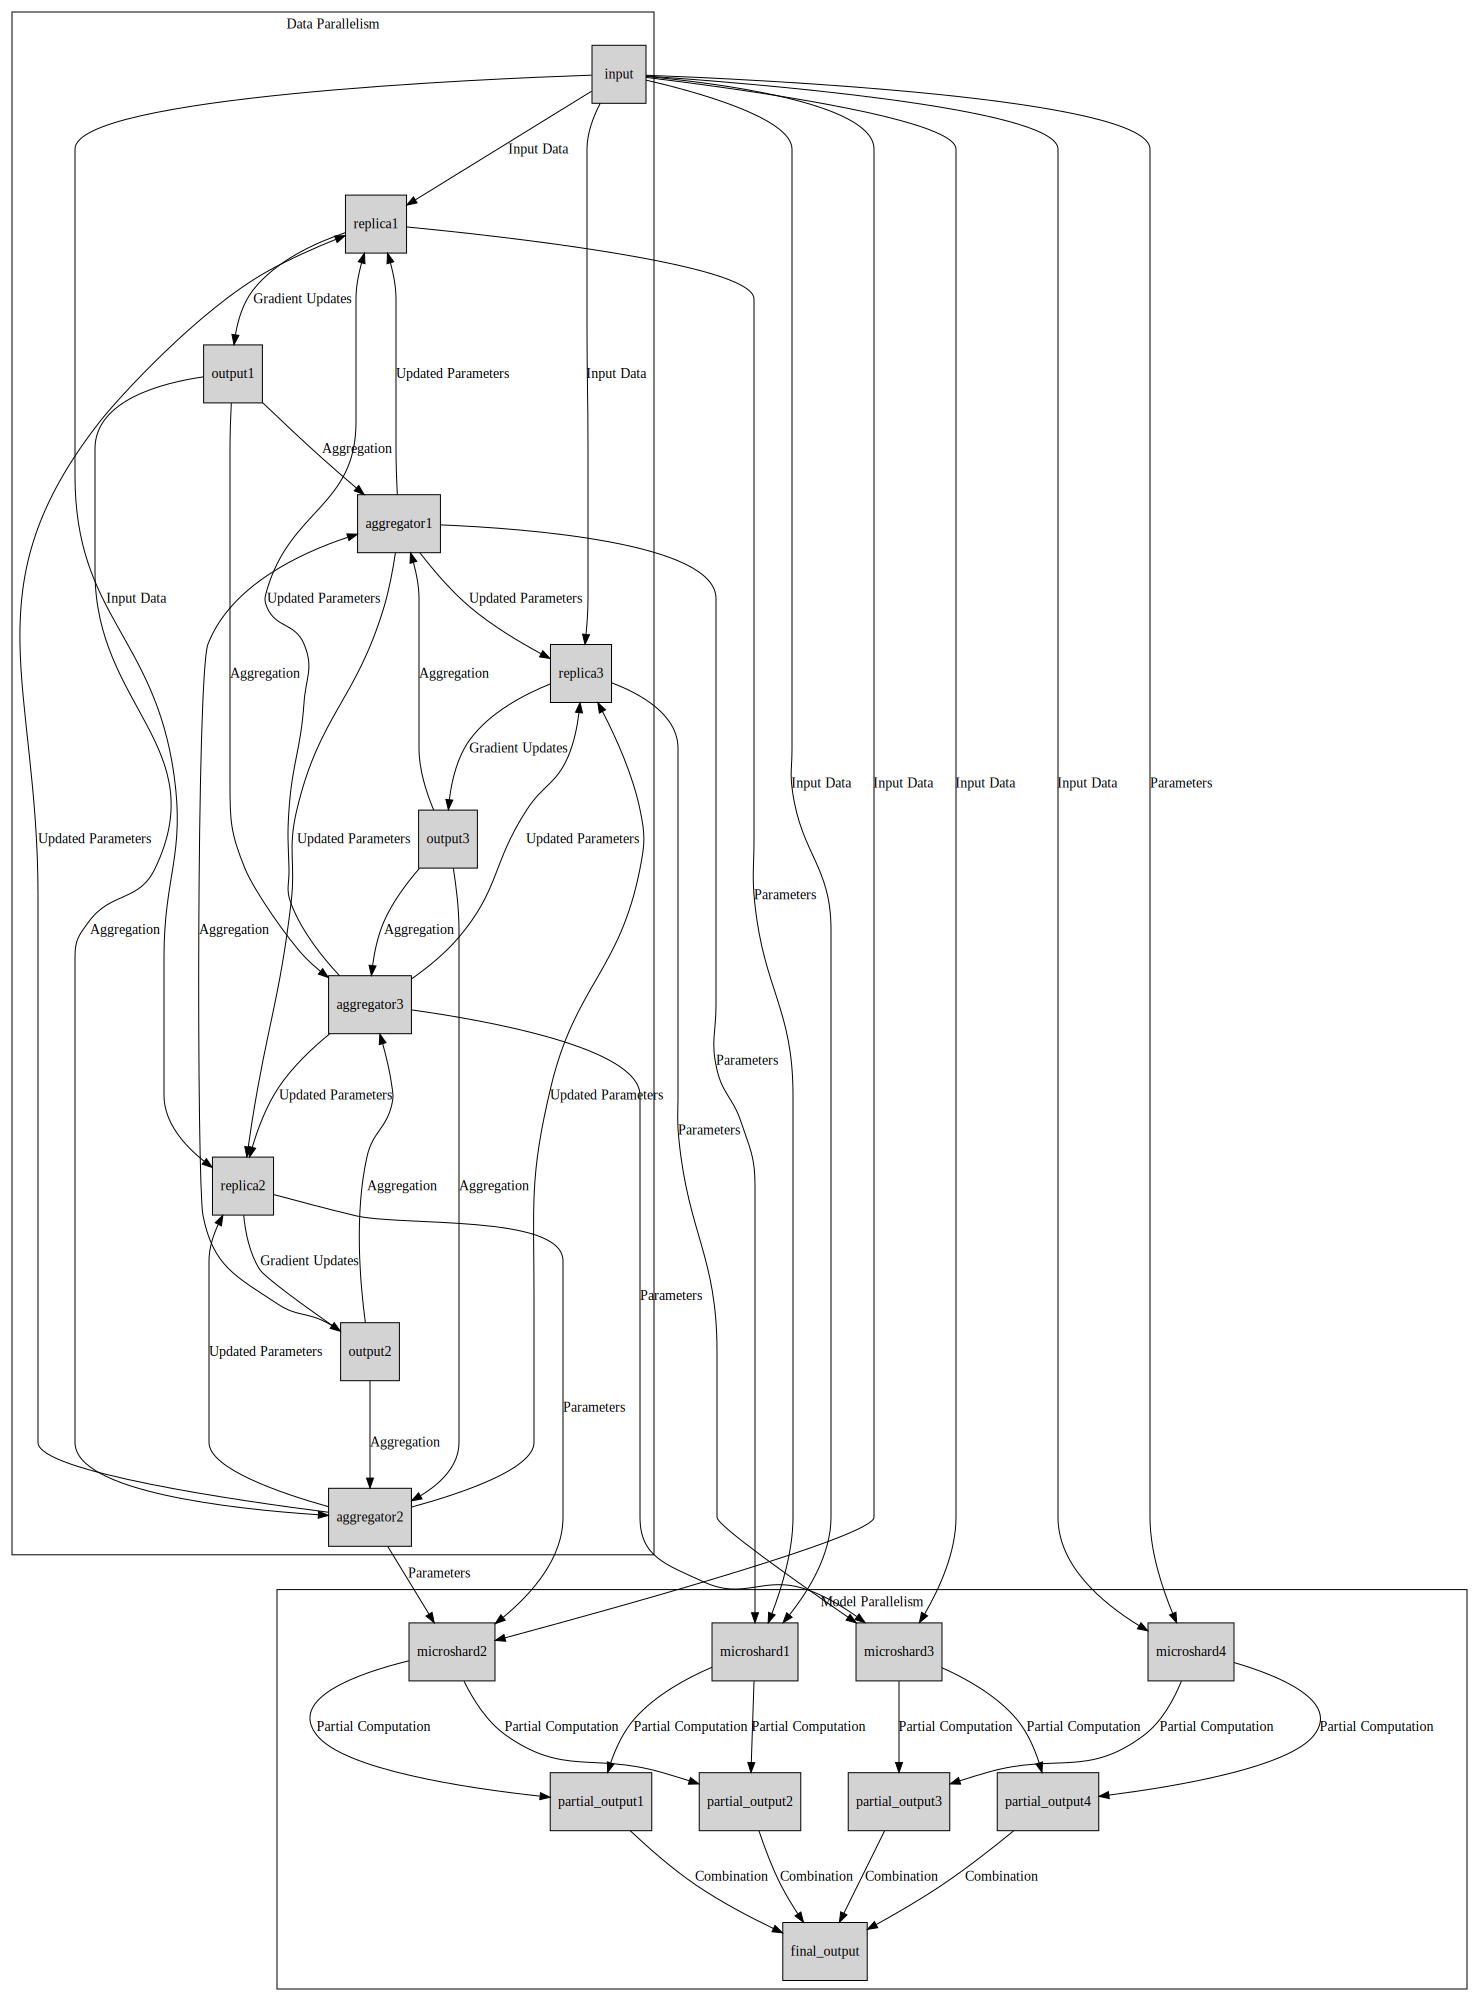

In [1]:
from IPython.display import SVG, display

# Load the SVG file and display it
svg_file = '/kaggle/input/notebook-images/gshard.svg'
display(SVG(filename=svg_file))

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Installing relevant versions of torch and torchtext
    </div>

In [1]:
!pip install -U torch==1.11.0 torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.11.0 which is incompatible.


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Importing modules    </div>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext.data.field import Field
from torchtext.data.example  import Example
from torchtext.data.dataset import Dataset
from torchtext.data import BucketIterator
import random
import sqlite3
import spacy
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Downloading language models for french and english    </div>

In [3]:
!python -m spacy download fr_core_news_sm
!python -m spacy download en_core_web_sm


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining SRC and TRG fields    </div>

In [4]:
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("fr_core_news_sm")


SRC = Field(tokenize='spacy', tokenizer_language='en_core_web_sm', init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True, fix_length=16) #we intentionally fixed it, you can change it
TRG = Field(tokenize='spacy', tokenizer_language='fr_core_news_sm', init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True, fix_length=16)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining the source and target language paths, They are same having different tables for different languages.    </div>

In [5]:
src_file_path = "/kaggle/input/wikibooks-dataset/wikibooks.sqlite"
trg_file_path = "/kaggle/input/wikibooks-dataset/wikibooks.sqlite"

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Function for preprocessing sentences    </div>

In [6]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import string

# Download the NLTK stop words and punctuation symbols
nltk.download("stopwords")
nltk.download("punkt")

# Define the sentence tokenization and cleaning function
def preprocess_sentences(text):
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    # Remove stop words and punctuation from each sentence
    stop_words = set(stopwords.words("english"))
    cleaned_sentences = []
    for sent in sentences:
        words = sent.split()
        words = [word for word in words if word.lower() not in stop_words and word not in string.punctuation]
        cleaned_sent = " ".join(words)
        cleaned_sentences.append(cleaned_sent)
    return cleaned_sentences

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Function for extracting parallel paris from SQLite files    </div>

In [7]:
def extract_parallel_pairs(file_path, src_table, trg_table):
    conn = sqlite3.connect(file_path)
    cursor = conn.cursor()
    cursor.execute(f"SELECT {src_table}.body_text, {trg_table}.body_text FROM {src_table} INNER JOIN {trg_table} ON {src_table}.title={trg_table}.title")
    rows = cursor.fetchall()
    parallel_pairs = []
    for row in tqdm(rows):
        src_text = row[0]
        trg_text = row[1]
        # Perform sentence tokenization and cleaning
        src_sentences = preprocess_sentences(src_text)
        trg_sentences = preprocess_sentences(trg_text)
        # Create parallel sentence pairs
        for src_sent, trg_sent in tqdm(zip(src_sentences, trg_sentences)):
            parallel_pairs.append((src_sent, trg_sent))
    return parallel_pairs

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Preprocessing SQLite files to extract parallel files    </div>

In [8]:
parallel_pairs = []
parallel_pairs += extract_parallel_pairs(src_file_path, "en", "de")


  0%|          | 0/28 [00:00<?, ?it/s]
6it [00:00, 57587.70it/s]

3it [00:00, 38245.93it/s]

1it [00:00, 13842.59it/s]

74it [00:00, 447231.26it/s]

1it [00:00, 13443.28it/s]

1it [00:00, 5540.69it/s]

21it [00:00, 83726.60it/s]

2it [00:00, 10852.02it/s]

7it [00:00, 36472.21it/s]
 32%|███▏      | 9/28 [00:00<00:00, 89.99it/s]
10it [00:00, 52560.20it/s]

9it [00:00, 125411.08it/s]

1it [00:00, 15420.24it/s]

5it [00:00, 68089.35it/s]

149it [00:00, 600337.46it/s]

3it [00:00, 13647.41it/s]

5it [00:00, 59578.18it/s]

1it [00:00, 4519.72it/s]

10it [00:00, 48321.47it/s]
 64%|██████▍   | 18/28 [00:00<00:00, 50.78it/s]
11it [00:00, 44066.23it/s]

6it [00:00, 25601.04it/s]

21it [00:00, 85932.08it/s]

6it [00:00, 28339.89it/s]

16it [00:00, 73503.68it/s]

5it [00:00, 65536.00it/s]

32it [00:00, 321865.06it/s]

15it [00:00, 177224.11it/s]

11it [00:00, 158547.57it/s]
 96%|█████████▋| 27/28 [00:00<00:00, 62.38it/s]
11it [00:00, 118300.88it/s]
100%|██████████| 28/28 [00:00<00:00, 62.76it/s]


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Inspecting length of generated pairs
    </div>

In [9]:
print(len(parallel_pairs))

443


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Shuffling into train, val and test pairs
    </div>

In [10]:
random.shuffle(parallel_pairs)
train_pairs = parallel_pairs[:240]
valid_pairs = parallel_pairs[240:300]
test_pairs = parallel_pairs[300:]

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Defining examples for the dataset
    </div>

In [11]:
train_examples = [Example.fromlist(pair, fields=[('src', SRC), ('trg', TRG)]) for pair in train_pairs]
valid_examples = [Example.fromlist(pair, fields=[('src', SRC), ('trg', TRG)]) for pair in valid_pairs]
test_examples = [Example.fromlist(pair, fields=[('src', SRC), ('trg', TRG)]) for pair in test_pairs]


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Extracting src and target fields from train examples along with building the vocab    </div>

In [12]:
src_train_examples = [example.src for example in train_examples]
trg_train_examples = [example.trg for example in train_examples]

SRC.build_vocab(src_train_examples, min_freq=2)
TRG.build_vocab(trg_train_examples, min_freq=2)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining the GShard model architecture for machine translation task    </div>

In [13]:
class GShardTranslator(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, num_microshards, num_transformers):
        super(GShardTranslator, self).__init__()
        self.num_microshards = num_microshards
        self.num_transformers = num_transformers

        self.src_embedding = nn.Embedding(src_vocab_size, 512)
        self.trg_embedding = nn.Embedding(trg_vocab_size, 512)

        self.microshards = nn.ModuleList()
        for i in range(num_microshards):
            microshard = nn.ModuleList()
            for j in range(num_transformers):
                transformer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
                microshard.append(transformer)
            self.microshards.append(microshard)

        self.linear = nn.Linear(512, trg_vocab_size)

    def forward(self, src, trg):
        src_replicas = torch.split(src, src.shape[0] // self.num_microshards)
        trg_replicas = torch.split(trg, trg.shape[0] // self.num_microshards)
        microshard_outputs = []
        for i in range(self.num_microshards):
            src_input = src_replicas[i]
            trg_input = trg_replicas[i]
            src_output = self.src_embedding(src_input)
            trg_output = self.trg_embedding(trg_input)
            for j in range(self.num_transformers):
                transformer = self.microshards[i][j]
                src_output = transformer(src_output)[:,:15,:]#Truncating to 15 size
                trg_output = transformer(trg_output)[:,:15,:]
                #print("src_output shape:", src_output.shape)
                #print("trg_output shape:", trg_output.shape)
            output = src_output + trg_output
            microshard_outputs.append(output)
        x = torch.cat(microshard_outputs, dim=0)
        x = self.linear(x)
        return x

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining the train loop    </div>

In [14]:
def train(model, iterator, optimizer, criterion, clip, device):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, trg)
        # Flatten the output and target tensors
        output = output.view(-1, output.shape[-1])
        trg = trg.view(-1)
        # Pad the output tensor with zeros if the batch sizes don't match
        if output.shape[0] < trg.shape[0]:
            pad_size = trg.shape[0] - output.shape[0]
            padding = torch.zeros(pad_size, output.shape[-1]).to(device)
            output = torch.cat((output, padding), dim=0)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining the evaluate function for val and test</div>

In [15]:
def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            output = model(src, trg)
            output = output.view(-1, output.shape[-1])
            trg = trg.view(-1)
            
            # Pad output with zeros to match trg batch size
            if output.shape[0] < trg.shape[0]:
                pad_size = trg.shape[0] - output.shape[0]
                padding = torch.zeros((pad_size, output.shape[1]), device=device)
                output = torch.cat([output, padding], dim=0)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    if len(iterator) > 0:
        return epoch_loss / len(iterator)
    else:
        return 0


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining the main function to train and evaluate the model    </div>

In [18]:
def main():
    # Define the hyperparameters for the model
    BATCH_SIZE = 64
    NUM_MICROSHARDS = 4
    NUM_TRANSFORMERS = 2
    LR = 0.0005
    CLIP = 1

    # Create the datasets and iterators for the training, validation, and test sets
    train_data = Dataset(train_examples, fields=[('src', SRC), ('trg', TRG)])
    valid_data = Dataset(valid_examples, fields=[('src', SRC), ('trg', TRG)])
    test_data = Dataset(test_examples, fields=[('src', SRC), ('trg', TRG)])
    train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size=BATCH_SIZE,
        sort_within_batch=True,
        sort_key=lambda x: len(x.src),
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Create the model, optimizer, and criterion
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    src_vocab_size = len(SRC.vocab)
    trg_vocab_size = len(TRG.vocab)
    model = GShardTranslator(src_vocab_size, trg_vocab_size, NUM_MICROSHARDS, NUM_TRANSFORMERS)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi[TRG.pad_token])

    # Train the model
    N_EPOCHS = 100
    best_valid_loss = float('inf')
    for epoch in range(N_EPOCHS):
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP,device)
        valid_loss = evaluate(model, valid_iterator, criterion,device)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'gshard_translator.pth')
        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f}')

    # Evaluate the model on the test set
    model.load_state_dict(torch.load('gshard_translator.pth'))
    test_loss = evaluate(model, test_iterator, criterion,device)
    print(f'Test Loss: {test_loss:.3f}')

In [19]:
main()

Epoch: 01 | Train Loss: 6.243
Epoch: 02 | Train Loss: 5.047
Epoch: 03 | Train Loss: 4.792
Epoch: 04 | Train Loss: 4.569
Epoch: 05 | Train Loss: 4.426
Epoch: 06 | Train Loss: 4.379
Epoch: 07 | Train Loss: 4.331
Epoch: 08 | Train Loss: 4.205
Epoch: 09 | Train Loss: 4.237
Epoch: 10 | Train Loss: 4.211
Epoch: 11 | Train Loss: 4.160
Epoch: 12 | Train Loss: 4.090
Epoch: 13 | Train Loss: 4.065
Epoch: 14 | Train Loss: 4.058
Epoch: 15 | Train Loss: 4.031
Epoch: 16 | Train Loss: 3.948
Epoch: 17 | Train Loss: 3.934
Epoch: 18 | Train Loss: 3.957
Epoch: 19 | Train Loss: 3.874
Epoch: 20 | Train Loss: 3.939
Epoch: 21 | Train Loss: 3.911
Epoch: 22 | Train Loss: 3.895
Epoch: 23 | Train Loss: 3.816
Epoch: 24 | Train Loss: 3.867
Epoch: 25 | Train Loss: 3.840
Epoch: 26 | Train Loss: 3.787
Epoch: 27 | Train Loss: 3.740
Epoch: 28 | Train Loss: 3.766
Epoch: 29 | Train Loss: 3.759
Epoch: 30 | Train Loss: 3.790
Epoch: 31 | Train Loss: 3.705
Epoch: 32 | Train Loss: 3.743
Epoch: 33 | Train Loss: 3.686
Epoch: 34 

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Conclusion(s):<br>
1. We have incorporated padding in train and evaluate functions, you can remove it by addressing proper techniques by ensuring batches are of same length; For example via a collate function.<br>
2. The model is defined as a custom module, It'll be interesting to see how it performs when trained significantly.<br>
</div>

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
If you like the notebook, Feel free to check out my other LLM notebooks too and show some love which'll keep me motivated to publish similar kernels ! <3
</div>